<a href="https://colab.research.google.com/github/fikrinotes/100-days-of-code/blob/master/Final_Project_IDS_with_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrusion Detection System

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

dataset_path = kagglehub.dataset_download('chethuhn/network-intrusion-dataset')

print('Data source import complete. \n')
print("Information about your data sources:")
print(f"Dataset path: {dataset_path}")

Data source import complete. 

Information about your data sources:
Dataset path: /kaggle/input/network-intrusion-dataset


## Import Library

In [3]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Preprocessing Data

### Load Data

In [4]:
# Fungsi untuk membaca dan preprocessing setiap file
def read_and_clean_file(file_path):
    print(f"Membaca file: {file_path}")
    df = pd.read_csv(file_path, low_memory=False, sep=",")

    # Bersihkan nama kolom dari whitespace
    df.columns = df.columns.str.strip()

    # Hapus kolom yang tidak diperlukan
    redundant_column = ['Destination Port']
    df = df.drop(redundant_column, axis=1)

    # drop baris yang tidak punya label
    df.dropna(subset = ['Label'], inplace=True)

    # Handling missing values dan infinite values
    df = df.replace([np.inf, -np.inf], np.nan)

    return df


# Baca semua file CSV dari folder
data1 = dataset_path + "/Monday-WorkingHours.pcap_ISCX.csv"
data2 = dataset_path + "/Tuesday-WorkingHours.pcap_ISCX.csv"
data3 = dataset_path + "/Wednesday-workingHours.pcap_ISCX.csv"
data4 = dataset_path + "/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
data5 = dataset_path + "/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
data6 = dataset_path + "/Friday-WorkingHours-Morning.pcap_ISCX.csv"
data7 = dataset_path + "/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"
data8 = dataset_path + "/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"


# Buat list semua dataset yang tersedia
all_files = [data2, data3, data4, data5, data6, data7, data8]

# Membaca file dan mengkonversi semua data file dari list "all_files" menjadi dataframe
dataframes = []
for file in all_files:
    df = read_and_clean_file(file)
    dataframes.append(df)
    del df

# Menggabungkan semua dataframe
print("Menggabungkan semua file...")
df = pd.concat(dataframes, ignore_index=True)
try:
    print("Semua file dataset berhasil digabungkan!")
except:
    print("Error! file dataset tidak berhasil digabungkan")

Membaca file: /kaggle/input/network-intrusion-dataset/Tuesday-WorkingHours.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Wednesday-workingHours.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Membaca file: /kaggle/input/network-intrusion-dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Menggabungkan semua file...
Semua file dataset berhasil digabungkan!


### Pembersihan Data Duplikat

In [5]:
# ganti nama kolom dengan cara hapus whitespaces
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

# informasi data duplikat
dups = df[df.duplicated()]
print(f'Banyak data duplikat : {len(dups)}')
print(f'Banyak data sebelum duplikat : {df.shape[0]}')

print("menghapus data duplikat...")

# Hapus data duplikat
df.drop_duplicates(inplace = True)
print("data duplikat selesai dihapus!")
df.shape
print(f"banyak data setelah data duplikat dihapus : {df.shape[0]}")

Banyak data duplikat : 524101
Banyak data sebelum duplikat : 2300825
menghapus data duplikat...
data duplikat selesai dihapus!
banyak data setelah data duplikat dihapus : 1776724


### Persiapan Label Kelas untuk Klasifikasi Biner

In [6]:
# konversi semua label selain BENIGN jadi ATTACK
df["Label"] = df["Label"].where(df["Label"] == "BENIGN", "ATTACK")
print("Informasi Kelas : ")
df["Label"].unique()

Informasi Kelas : 


array(['BENIGN', 'ATTACK'], dtype=object)

## Informasi Umum Dataset

In [7]:
# Menampilkan informasi dataset
print("\nInformasi Dataset:")
print(f"\nJumlah total data: {len(df)}")
print(f"Jumlah fitur : {len(df.columns)}")
print("\nDistribusi Label sebelum preprocessing:")

# tabel distribusi label
def create_distribution_table(df):
    label_dist = pd.DataFrame(df['Label'].value_counts())
    label_dist['percentage'] = df['Label'].value_counts()/len(df)
    return label_dist

create_distribution_table(df)


Informasi Dataset:

Jumlah total data: 1776724
Jumlah fitur : 78

Distribusi Label sebelum preprocessing:


,count,percentage
Label,,
BENIGN,1440219,0.810604
ATTACK,336505,0.189396


## Pemisahan Data Fitur (X) dan Output (y)

In [8]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
X = df[numerical_columns]
y = df["Label"]
print(f"jumlah fitur : {len(X.columns)}")
print(f"jumlah label : {len(y.unique())}")

jumlah fitur : 77
jumlah label : 2


In [9]:

# Memisahkan data menjadi training, validation, dan testing dengan stratify
# Menggunakan train_test_split dua kali: pertama untuk memisahkan training dan temp (validation + test),
# kemudian temp dipisah menjadi validation dan test

# Pertama, pisahkan data menjadi training dan temporary (untuk validation dan test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Kedua, pisahkan temporary menjadi validation dan testing
# Ukuran test_size=0.5 berarti membagi temporary set (30% dari data asli) menjadi dua bagian yang sama besar (15% validation dan 15% test dari data asli)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Ukuran data training (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Ukuran data validation (X_val, y_val): {X_val.shape}, {y_val.shape}")
print(f"Ukuran data testing (X_test, y_test): {X_test.shape}, {y_test.shape}")

# Memeriksa distribusi label di setiap set
print("\nDistribusi Label pada Training Set:")
print(y_train.value_counts(normalize=True))

print("\nDistribusi Label pada Validation Set:")
print(y_val.value_counts(normalize=True))

print("\nDistribusi Label pada Testing Set:")
print(y_test.value_counts(normalize=True))

Ukuran data training (X_train, y_train): (1243706, 77), (1243706,)
Ukuran data validation (X_val, y_val): (266509, 77), (266509,)
Ukuran data testing (X_test, y_test): (266509, 77), (266509,)

Distribusi Label pada Training Set:
Label
BENIGN    0.810604
ATTACK    0.189396
Name: proportion, dtype: float64

Distribusi Label pada Validation Set:
Label
BENIGN    0.810603
ATTACK    0.189397
Name: proportion, dtype: float64

Distribusi Label pada Testing Set:
Label
BENIGN    0.810603
ATTACK    0.189397
Name: proportion, dtype: float64


## Transformasi Data

In [10]:
# imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
print("fitting imputer...")
imputer.fit(X_train)
print("selesai!")

# scaler
scaler = StandardScaler(copy=False)
print("\nfitting scaler...")
scaler.fit(X_train)
print("selesai!")

# label encoder (le)
le = LabelEncoder()
print("\nfitting label encoder...")
le.fit(y_train.astype(str))
print("selesai!")

fitting imputer...
selesai!

fitting scaler...
selesai!

fitting label encoder...
selesai!


In [11]:
for i, label in enumerate(le.classes_):
    print(f"i : {i} , label : {label}")

i : 0 , label : ATTACK
i : 1 , label : BENIGN


In [12]:
# Menampilkan informasi kelas
print("\nKelas yang terdeteksi:")
for i, label in enumerate(le.classes_):
    count = (df["Label"] == le.classes_[i]).sum()
    print(f"{label}: {count} samples (encoded as {i})")


Kelas yang terdeteksi:
ATTACK: 336505 samples (encoded as 0)
BENIGN: 1440219 samples (encoded as 1)


In [13]:
def transform_data(X, y, scaler, imputer, le):
    # Handling missing values untuk dataset training
    print("\nMenangani missing values...")
    X = imputer.transform(X)
    print("selesai!")

    # Normalisasi Data
    print("\nMelakukan normalisasi data...")
    X = scaler.transform(X)
    print("selesai!")

    # Pelabelan Kelas
    num_classes = len(le.classes_)
    print("\nMelakukan one-hot encoding...")
    y = le.transform(y)
    print("selesai!")

    return X, y

In [14]:
## Transformasi Data Training
X_train, y_train = transform_data(X_train, y_train, scaler, imputer, le)

## Transformasi Data Validation
X_val, y_val = transform_data(X_val, y_val, scaler, imputer, le)

# Transformmasi data testing
X_test, y_test = transform_data(X_test, y_test, scaler, imputer, le)


Menangani missing values...
selesai!

Melakukan normalisasi data...
selesai!

Melakukan one-hot encoding...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


selesai!

Menangani missing values...
selesai!

Melakukan normalisasi data...
selesai!

Melakukan one-hot encoding...
selesai!

Menangani missing values...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


selesai!

Melakukan normalisasi data...
selesai!

Melakukan one-hot encoding...
selesai!


## Konstruksi Model DNN

In [17]:
# prompt: buat model neural network dengan 3 layer dan jumlah neuron masing masing 32, 64, dan 32 untuk masalah klasifikasi biner

# Membangun model DNN
input_shape = (X_train.shape[1],) # Bentuk input sesuai dengan jumlah fitur

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Dense(32, activation='relu'), # Layer pertama dengan 32 neuron
    layers.Dense(64, activation='relu'), # Layer kedua dengan 64 neuron
    layers.Dense(32, activation='relu'), # Layer ketiga dengan 32 neuron
    layers.Dense(1, activation='sigmoid') # Output layer dengan 1 neuron (untuk klasifikasi biner) dan sigmoid
])

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'precision', 'recall'])

history = model.fit(X_train, y_train,
                    epochs=70,
                    batch_size=128,
                    validation_data=(X_val, y_val)
                   )

# Menampilkan ringkasan model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/70
9717/9717 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9594 - loss: 0.1391 - precision: 0.9571 - recall: 0.9950 - val_accuracy: 0.9824 - val_loss: 0.0548 - val_precision: 0.9825 - val_recall: 0.9960
Epoch 2/70
9717/9717 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9839 - loss: 0.0508 - precision: 0.9845 - recall: 0.9959 - val_accuracy: 0.9850 - val_loss: 0.0448 - val_precision: 0.9849 - val_recall: 0.9968
Epoch 3/70
9717/9717 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9856 - loss: 0.0428 - precision: 0.9854 - recall: 0.9970 - val_accuracy: 0.9857 - val_loss: 0.0397 - val_precision: 0.9857 - val_recall: 0.9968
Epoch 4/70
9717/9717 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9860 - loss: 0.0382 - precision: 0.9860 - recall: 0.9969 - val_accuracy: 0.9858 - val_loss: 0.0361 - val_precision: 0.9861 - val_recall: 0.9966
Epoch 5/70
9717/9717 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.9866 - loss: 0.0347 - precision: 0.9865 - recall: 0.9972 - val_accuracy: 0.9877

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 32)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,165 (78.77 KB)

 Trainable params: 6,721 (26.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,444 (52.52 KB)

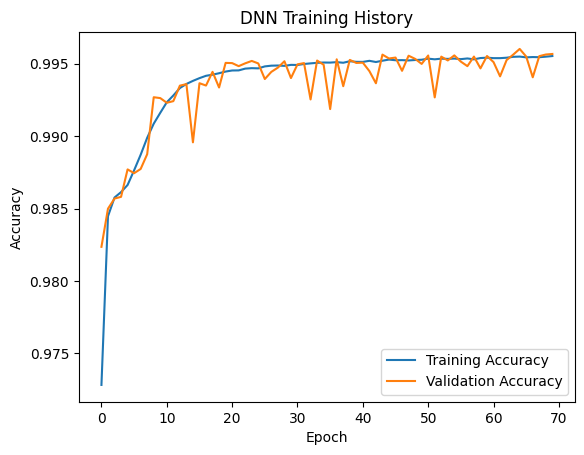

In [18]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('DNN Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("training_history")

In [20]:
# Evaluasi model
y_pred_prob = model.predict(X_test)
y_pred_classes = (y_pred_prob > 0.5).astype(int)
y_test_classes = y_test

# Tampilkan hasil evaluasi
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

8329/8329 ━━━━━━━━━━━━━━━━━━━━ 5s 647us/step

Classification Report:
              precision    recall  f1-score   support

      ATTACK       0.99      0.98      0.99     50476
      BENIGN       1.00      1.00      1.00    216033

    accuracy                           1.00    266509
   macro avg       0.99      0.99      0.99    266509
weighted avg       1.00      1.00      1.00    266509



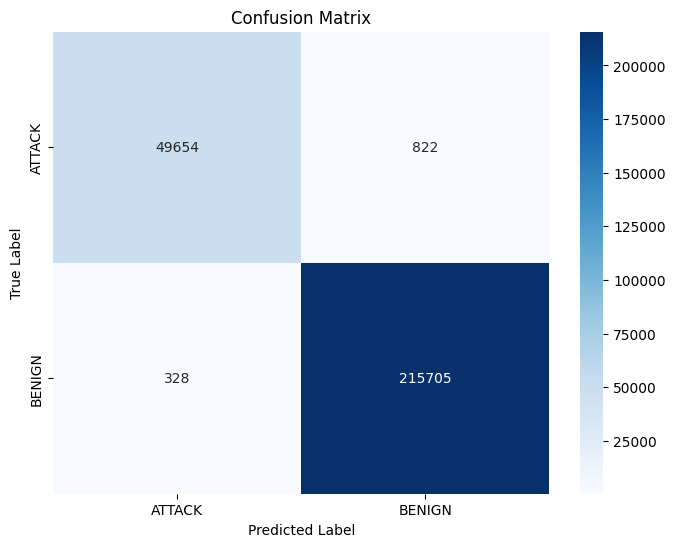

In [25]:
import matplotlib.pyplot as plt
# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [24]:
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(y_test_classes, y_pred_classes)
print(f"Balanced Accuracy: {balanced_acc}")

Balanced Accuracy: 0.9910983731644222


In [26]:
# Simpan model
print("\nMenyimpan model...")
model.save('model.keras')


Menyimpan model...


In [27]:
import pickle

# Simpan history ke file
with open('history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [28]:
# Simpan label encoder
import joblib
joblib.dump(le, 'label_encoder.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(imputer, 'imputer.joblib')

['imputer.joblib']